# Import libraries

In [633]:
import os
import subprocess
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

In [634]:
# Function to pair SNPs and summarize genotype
def summarize_genotypes(df):
    summarized_genotypes = {}
    # Iterate over pairs of columns
    for i in range(1, df.shape[1], 2):
        pair_sum = df.iloc[:, i-1] + df.iloc[:, i]
        # Apply the genotype summarization logic
        summarized_genotypes[f'G{i//2 + 1}'] = np.where(pair_sum == 2, 2, pair_sum)
    return pd.DataFrame(summarized_genotypes)

# Function to flip 0s to 2s and 2s to 0s
def flip_genotypes(row):
    if row['AFs'] > 0.5:
        # Apply transformation for the condition
        row[:-1] = row[:-1].replace({0: 2, 2: 0})
        row['AFs'] = 1 - row['AFs']  # Adjust allele frequency
    return row

def contains_all_genotypes(series, genotypes={0.0, 1.0, 2.0}):
    return genotypes.issubset(series.unique())

In [635]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [636]:
dict = parse_variables('geno_simulation.txt')
G = 10
L = 10
c = 50
k = 2
M = .1
HWE = 1

# Define the R commands to run, passing parameters as arguments
commands = [
    f"source('geno_simulation.txt')",
    f"source('create_geno.R', echo=TRUE)",
]


commands = [
    "source('geno_simulation.txt')",
    f"G <- {G}",
    f"L <- {L}",
    f"c <- {c}",
    f"k <- {k}",
    f"M <- {M}",
    "source('create_geno.R', echo=TRUE)"
]

# Concatenate commands into a single string
r_script = ";".join(commands)

# Run the R script
result = subprocess.run(['Rscript', '-e', r_script], capture_output=True, text=True)

# Print the output
#print(result.stdout)

# Check for errors
if result.returncode != 0:
    print("Error executing R script:")
    print(result.stderr)
    pass

os.makedirs(f"data/concept/genotype/raw",exist_ok=True)
os.system(f"mv simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv data/concept/genotype/raw/")

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

file = f"data/concept/genotype/raw/simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv"
path_simulated_file = "./"+ file
number_of_loci = G*L
number_of_individuals = c*k*k
simulated_loci= pd.read_csv(path_simulated_file)

In [637]:
# Apply the function to the sample DataFrame
simulated_genotype = summarize_genotypes(simulated_loci)
columns_to_drop  = simulated_genotype.columns[simulated_genotype.nunique() == 1] # If double columns delete it 
simulated_genotype = simulated_genotype.drop(columns=columns_to_drop)

In [638]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

simulated_genotype["populations"] = labels_pop
simulated_genotype['populations'] = simulated_genotype['populations'].apply(lambda x: 1 if x in [1, 2] else 2)

In [639]:
unique_pops = simulated_genotype['populations'].unique()
unique_pops.sort()
dfs = []
required_values = {0, 1, 2}

# Optimization: Cache the set operation result
simulated_genotype_sets = {col: set(simulated_genotype[col]) for col in simulated_genotype.columns}

if HWE == 1:
    for pop in unique_pops:
        temp_pop = simulated_genotype[simulated_genotype["populations"] == pop].drop('populations', axis=1)
        
        for col in temp_pop.columns:
            column_values = simulated_genotype_sets[col]
            
            if not required_values.issubset(column_values):
                # Optimization: Vectorized random choice and assignment
                indices = np.random.choice(temp_pop.index, size=3, replace=False)
                temp_pop.loc[indices[0], col] = 0
                temp_pop.loc[indices[1], col] = 1
                temp_pop.loc[indices[2], col] = 2

            # Calculate frequencies
            value_counts = temp_pop[col].value_counts().reindex([0, 1, 2], fill_value=0)
            total = value_counts.sum()
            q2 = value_counts[2] / total
            q = np.sqrt(q2)
            p = 1 - q
            freq_maj = p ** 2
            freq_het = 2 * p * q
            freq_min = q ** 2

            # Optimization: Vectorized assignment of new genotypes
            pop_geno = np.random.choice([1.0, 0.0, -1.0], size=total, p=[freq_maj, freq_het, freq_min])
            temp_pop[col] = pop_geno

        dfs.append(temp_pop)

else:
    print("HWE")
    for pop in unique_pops:
        temp_pop = simulated_genotype[simulated_genotype["populations"] == pop].drop('populations', axis=1)
        
        for col in temp_pop.columns:
            column_values = simulated_genotype_sets[col]
            
            if not required_values.issubset(column_values):
                # Optimization: Vectorized random choice and assignment
                indices = np.random.choice(temp_pop.index, size=3, replace=False)
                temp_pop.loc[indices[0], col] = 0
                temp_pop.loc[indices[1], col] = 1
                temp_pop.loc[indices[2], col] = 2

            # Calculate frequencies
            value_counts = temp_pop[col].value_counts().reindex([0, 1, 2], fill_value=0)
            total = value_counts.sum()
            q2 = value_counts[2] / total
            q = np.sqrt(q2)
            p = 1 - q
            freq_maj = p ** 2
            freq_het = q ** 2
            freq_min = 2 * p * q

            # Optimization: Vectorized assignment of new genotypes
            pop_geno = np.random.choice([1.0, 0.0, -1.0], size=total, p=[freq_maj, freq_het, freq_min])
            temp_pop[col] = pop_geno

        dfs.append(temp_pop)

# Concatenate all dataframes if needed
simulated_genotype = pd.concat(dfs, ignore_index=True)

In [640]:
simulated_genotype = simulated_genotype+1

In [641]:
# calculate when AF is > 0.5 and change the genotype
# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Calculate allele frequencies for each SNP column
for snp in simulated_genotype.columns:
    total_alleles = 2 * len(simulated_genotype[snp])  # Total number of alleles (2 alleles per sample)
    minor_allele_count = (2 * simulated_genotype[snp].value_counts().get(0, 0)) + simulated_genotype[snp].value_counts().get(1, 0)
    allele_frequency = minor_allele_count / total_alleles
    allele_frequencies[snp] = allele_frequency

In [642]:
temp = simulated_genotype.T
temp['AFs'] = allele_frequencies

In [643]:
# Apply the function across the DataFrame, row-wise
df_transformed = temp.apply(flip_genotypes, axis=1)

In [644]:
simulated_genotype = df_transformed.drop('AFs', axis=1).T
columns_to_drop  = simulated_genotype.columns[simulated_genotype.nunique() == 1] # If double columns delete it 
simulated_genotype = simulated_genotype.drop(columns=columns_to_drop)

In [645]:
simulated_genotype = simulated_genotype[[col for col in simulated_genotype.columns if contains_all_genotypes(simulated_genotype[col])]]

In [646]:
# calculate when AF is > 0.5 and change the genotype
# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Calculate allele frequencies for each SNP column
for snp in simulated_genotype.columns:
    total_alleles = 2 * len(simulated_genotype[snp])  # Total number of alleles (2 alleles per sample)
    minor_allele_count = (2 * simulated_genotype[snp].value_counts().get(0, 0)) + simulated_genotype[snp].value_counts().get(1, 0)
    allele_frequency = minor_allele_count / total_alleles
    allele_frequencies[snp] = allele_frequency

In [647]:
temp = simulated_genotype.T
temp['AFs'] = allele_frequencies
AFs = temp[['AFs']]

In [648]:
# Create slices as copies to avoid SettingWithCopyWarning
very_rare = temp[(temp['AFs'] > very_rare_threshold_L) & (temp['AFs'] <= very_rare_threshold_H)].copy()
rare = temp[(temp['AFs'] > rare_threshold_L) & (temp['AFs'] <= rare_threshold_H)].copy()
common = temp[(temp['AFs'] > common_threshold_L) & (temp['AFs'] <= common_threshold_H)].copy()

# Modify 'snps' column using .loc to avoid warnings
very_rare.loc[:, 'snps'] = very_rare.index + '_AF_' + very_rare['AFs'].astype(str)
very_rare.set_index('snps', inplace=True)
very_rare_to_save = very_rare.drop('AFs', axis=1).T
very_rare_afs = very_rare[['AFs']]

rare.loc[:, 'snps'] = rare.index + '_AF_' + rare['AFs'].astype(str)
rare.set_index('snps', inplace=True)
rare_to_save = rare.drop('AFs', axis=1).T
rare_afs = rare[['AFs']]

common.loc[:, 'snps'] = common.index + '_AF_' + common['AFs'].astype(str)
common.set_index('snps', inplace=True)
common_to_save = common.drop('AFs', axis=1).T
common_afs = common[['AFs']]

In [649]:
very_rare_to_save = very_rare_to_save.rename(columns=lambda x: 'VR' + x)/2
rare_to_save = rare_to_save.rename(columns=lambda x: 'R' + x)/2
common_to_save = common_to_save.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common_to_save, rare_to_save, very_rare_to_save], axis=1)
complete = ((complete*2)-1)

In [650]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

simulated_genotype["populations"] = labels_pop
simulated_genotype['populations'] = simulated_genotype['populations'].apply(lambda x: 1 if x in [1, 2] else 2)

In [651]:
complete['pop'] = simulated_genotype['populations']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []

for pop in complete['pop'].unique():
    temp = complete[complete['pop'] == pop].drop("pop", axis=1)

    # Count the number of major, heterozygous, and minor alleles
    counts = temp.apply(pd.Series.value_counts).fillna(0)

    num_maj = counts.loc[1.0]
    num_het = counts.loc[0.0]
    num_min = counts.loc[-1.0]

    total_humans = num_maj + num_het + num_min

    # Normalize to get frequencies instead of counts
    p2s = num_maj / total_humans
    twopqs = num_het / total_humans
    q2s = num_min / total_humans

    # Expand the normalized values across all rows for each population
    p2s_dfs.append(pd.DataFrame([p2s] * temp.shape[0], index=temp.index, columns=temp.columns))
    twopqs_dfs.append(pd.DataFrame([twopqs] * temp.shape[0], index=temp.index, columns=temp.columns))
    q2s_dfs.append(pd.DataFrame([q2s] * temp.shape[0], index=temp.index, columns=temp.columns))

# Drop "pop" from the original DataFrame
complete = complete.drop("pop", axis=1)

# Concatenate all population-specific DataFrames
true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

In [652]:
first_snp = list(complete.columns)[0]

In [653]:
geno = complete[[first_snp]]

In [654]:
p2_min_q2 = true_p2s - true_q2s
p2_min_q2 = p2_min_q2[[first_snp]]

In [655]:
populations = simulated_genotype[['populations']]

In [656]:

populations['x'] = populations['populations']
populations['y'] = 1
populations['z'] = 0.5

In [657]:
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

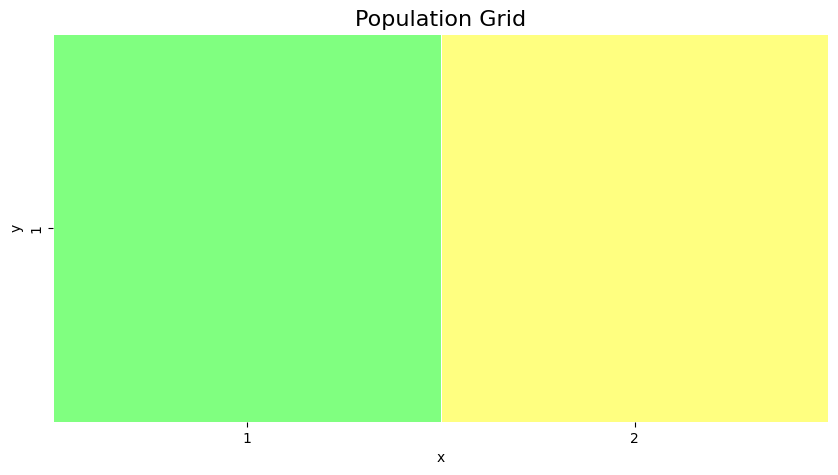

In [658]:
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

In [659]:
scaler = StandardScaler()
scaled_complete = scaler.fit_transform(complete)
n_components = max(min(complete.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_complete = pca.fit_transform(scaled_complete)
PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

In [660]:
to_have_collumns = ['populations', 'x', 'y']
PC_complete[to_have_collumns] = populations[to_have_collumns]

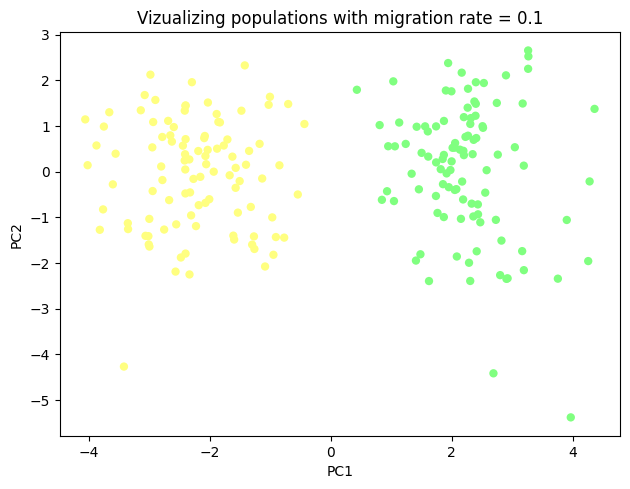

In [661]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [662]:
PC_complete['mafs'] = true_q2s[[first_snp]].apply(np.sqrt).round(2)

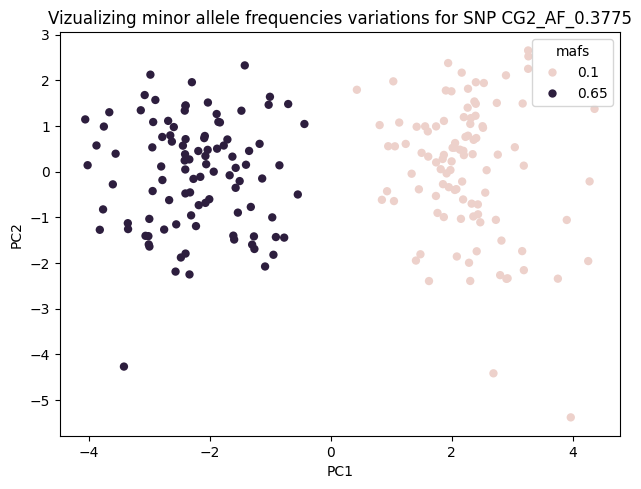

In [663]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mafs', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing minor allele frequencies variations for SNP {first_snp}")
plt.show()
plt.close()

In [664]:
risk = existing_risks[1]
risk

'NW_risk_fun'

In [665]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)


In [666]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
populations['x_temp'] = populations['x']/k
populations['y_temp'] = populations['y']/k
populations[name_risk] = list(populations.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
populations[name_risk] = populations[name_risk].astype('float')

In [667]:
PC_complete['risk'] = populations['NW_risk']

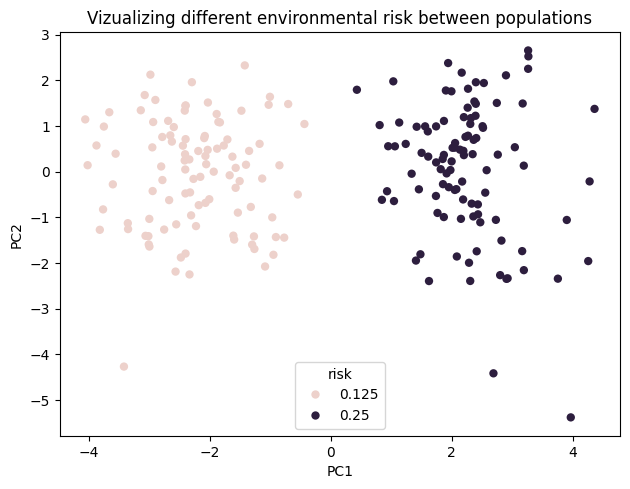

In [668]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'risk', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different environmental risk between populations")
plt.show()
plt.close()

In [669]:
# lets see what happens when we do a linear regression on this one SNP with different AF per pops

In [670]:
to_test = (complete[[first_snp]].copy() + 1)/2

to_test[f"{first_snp}_homozyg"] = p2_min_q2[[first_snp]]
to_test[f"{first_snp}_heterozyg"] = true_twopqs[[first_snp]]
to_test['has_hetero'] = 0
to_test.loc[to_test[first_snp] == 0.0, 'has_hetero'] = 1
to_test['pheno'] = PC_complete[['risk']]
to_test['pheno_updated'] = to_test['pheno']
to_test.loc[to_test[first_snp] == 0.0, 'pheno_updated'] = to_test['pheno'].mean()

In [671]:
to_test

snps,CG2_AF_0.3775,CG2_AF_0.3775_homozyg,CG2_AF_0.3775_heterozyg,has_hetero,pheno,pheno_updated
0,0.5,0.80,0.18,0,0.250,0.2500
1,1.0,0.80,0.18,0,0.250,0.2500
2,1.0,0.80,0.18,0,0.250,0.2500
3,1.0,0.80,0.18,0,0.250,0.2500
4,1.0,0.80,0.18,0,0.250,0.2500
...,...,...,...,...,...,...
195,0.0,-0.31,0.47,1,0.125,0.1875
196,0.5,-0.31,0.47,0,0.125,0.1250
197,0.5,-0.31,0.47,0,0.125,0.1250
198,0.0,-0.31,0.47,1,0.125,0.1875


In [672]:
only_risk_via_snps = manhattan_linear(to_test[[first_snp]], to_test[['pheno']])
only_risk_via_snps

,snp,coefs,AFs,Ps,-logPs
0,CG2,0.112809,0.3775,1.056488e-31,30.976136


In [673]:
only_risk_via_maf = manhattan_linear(to_test[[f"{first_snp}_homozyg"]], to_test[['pheno']])
only_risk_via_maf

,snp,coefs,AFs,Ps,-logPs
0,CG2,0.112613,0.3775_homozyg,0.0,inf


In [674]:
# If we update the pheno

In [675]:
only_risk_via_snps = manhattan_linear(to_test[[first_snp]], to_test[['pheno_updated']])
only_risk_via_snps

,snp,coefs,AFs,Ps,-logPs
0,CG2,0.060932,0.3775,4.805223e-11,10.318286


In [676]:
only_risk_via_maf = manhattan_linear(to_test[[f"{first_snp}_homozyg"]], to_test[['pheno_updated']])
only_risk_via_maf

,snp,coefs,AFs,Ps,-logPs
0,CG2,0.088401,0.3775_homozyg,5.736328e-78,77.241366


# Now with SNP causality

In [677]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

In [690]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in complete.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in complete.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
betas = pd.DataFrame(data)

In [692]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 0.5
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [693]:
# Beta value first snp

In [694]:
beta_value = betas.loc[betas['snp'] == first_snp.split('_AF_')[0], 'Beta'].values[0]
np.round(beta_value,3)

2.642

In [695]:
phenos_mono[[first_snp]]

snps,CG2_AF_0.3775
0,1.297751
1,1.472840
2,0.574988
3,1.968844
4,-0.229635
...,...
195,-0.819717
196,0.347819
197,0.901992
198,0.365874


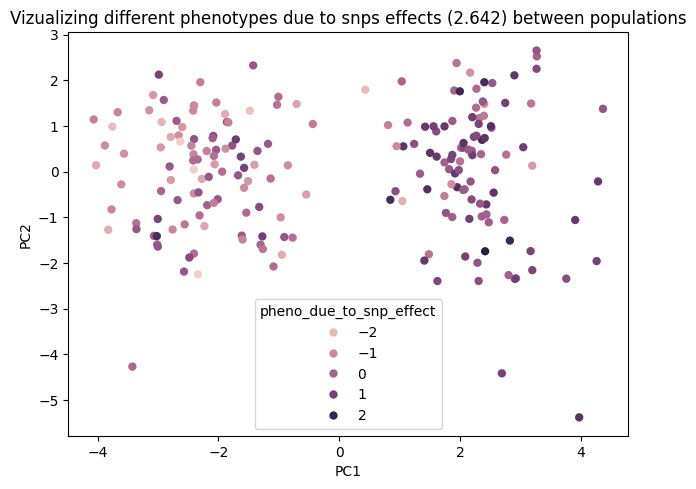

In [697]:
PC_complete['pheno_due_to_snp_effect'] = phenos_mono[[first_snp]]



# Add the calculated mean as a new column
PC_complete['mean pheno'] = mean_snp_effect_per_pop

sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'pheno_due_to_snp_effect', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

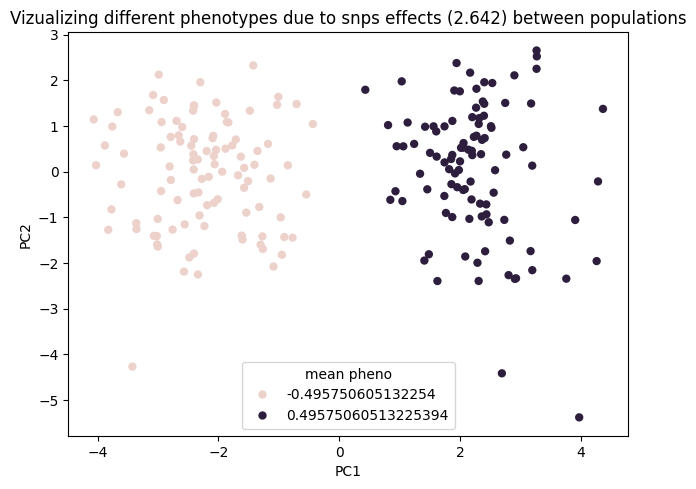

In [696]:

mean_snp_effect_per_pop = PC_complete.groupby('populations')['pheno_due_to_snp_effect'].transform('mean')

# Add the calculated mean as a new column
PC_complete['mean pheno'] = mean_snp_effect_per_pop

sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mean pheno', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

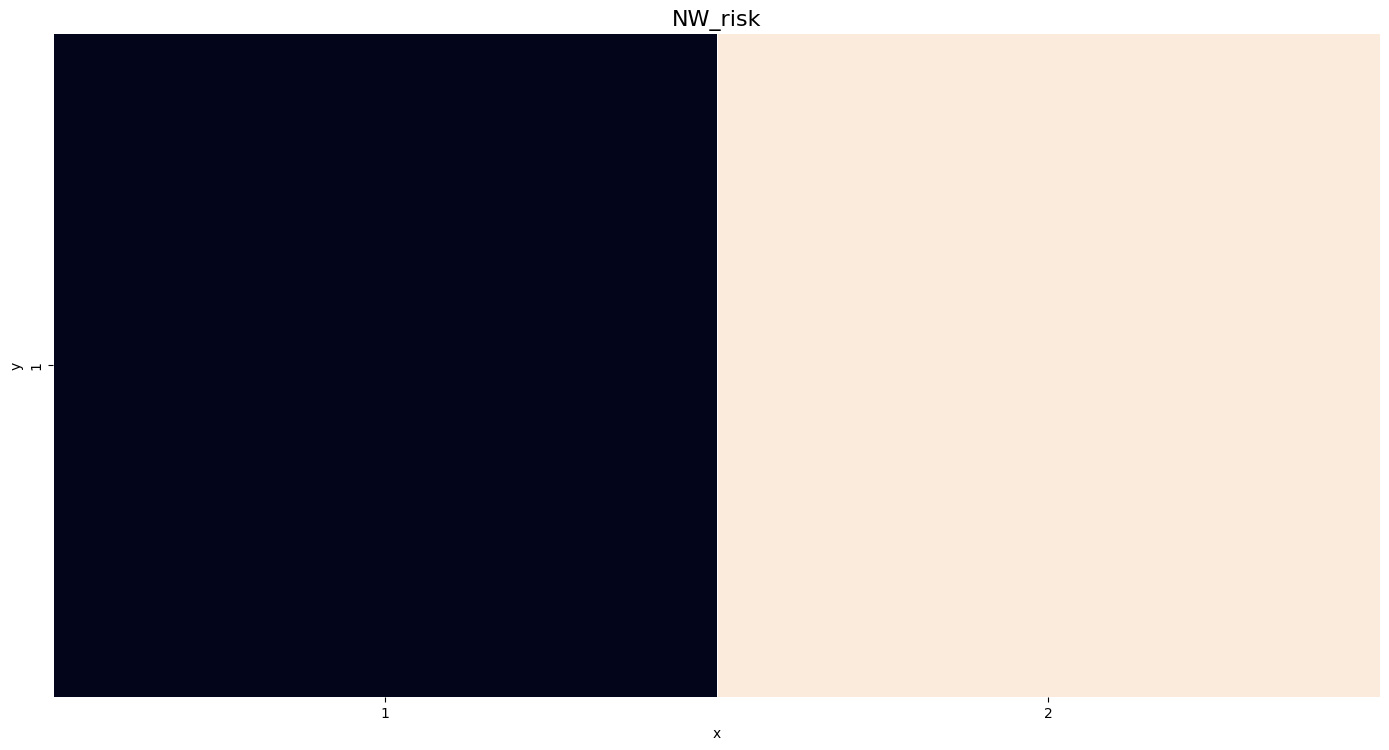

In [684]:
# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Set the title dynamically based on the value of name_risk
axs.set_title(name_risk, fontsize=16)

# Invert the y-axis
axs.invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()